<a href="https://colab.research.google.com/github/Steven-Macas/deepLearning_SAA/blob/main/deeepLearning_parte4_steven.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns 
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model

plt.rcParams['font.size'] = 14

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!unzip -n '/content/drive/MyDrive/archiveparte4.zip' >> /dev/null

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model

IMG_WIDTH = IMG_HEIGHT = 224


# Importar el modelo InceptionV3
inc_model = InceptionV3(include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("Número de capas:", len(inc_model.layers))

# Congelar las capas iniciales para que no se entrenen
for layer in inc_model.layers:
    layer.trainable = False

# Crear un generador de imágenes con validación de división
datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)

# Cargar y preprocesar los datos de entrenamiento y validación
train_generator = datagen.flow_from_directory(
    directory='raw-img',  # la ruta de nuestra carpeta de imágenes
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='categorical',
    subset='training',  # especificar este generador para datos de entrenamiento
    seed=123  # semilla para la reproducibilidad
)

validation_generator = datagen.flow_from_directory(
    directory='raw-img',  # la ruta de nuestra carpeta de imágenes
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='categorical',
    subset='validation',  # especificar este generador para datos de validación
    seed=123  # semilla para la reproducibilidad
)

# Agregar capas personalizadas
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(len(train_generator.class_indices), activation="softmax")(x)  # tantos nodos de salida como clases

# Crear el modelo final
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Compilar el modelo
model_.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

# Crear un objeto ModelCheckpoint para guardar el mejor modelo durante el entrenamiento
checkpointer = ModelCheckpoint(filepath='weights.best.inc.InceptionV3.hdf5', verbose=1, save_best_only=True)

# Entrenar el modelo
history = model_.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,  #ajustar este número según nuestras necesidades
    callbacks=[checkpointer],
)

# Guardar el modelo con los mejores pesos encontrados durante el entrenamiento
model_.load_weights('weights.best.inc.InceptionV3.hdf5')

# Evaluar el modelo en los datos de validación (en este caso, se utiliza como datos de prueba)
test_loss, test_accuracy = model_.evaluate(validation_generator)
print("Accuracy on test data: ", test_accuracy)

# Visualizar el modelo
plot_model(model_, to_file='model_InceptionV3.png', show_shapes=True, show_layer_names=True)


Número de capas: 311
Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.
Epoch 1/20
655/655 [==============================] - ETA: 0s - loss: 0.3948 - accuracy: 0.8889
Epoch 1: val_loss improved from inf to 0.13655, saving model to weights.best.inc.InceptionV3.hdf5
655/655 [==============================] - 113s 153ms/step - loss: 0.3948 - accuracy: 0.8889 - val_loss: 0.1366 - val_accuracy: 0.9583
Epoch 2/20
655/655 [==============================] - ETA: 0s - loss: 0.1763 - accuracy: 0.9480
Epoch 2: val_loss improved from 0.13655 to 0.13011, saving model to weights.best.inc.InceptionV3.hdf5
655/655 [==============================] - 96s 147ms/step - loss: 0.1763 - accuracy: 0.9480 - val_loss: 0.1301 - val_accuracy: 0.9604
Epoch 3/20
655/655 [==============================] - ETA: 0s - loss: 0.1510 - accuracy: 0.9551
Epoch 3: val_loss improved from 0.13011 to 0.11440, saving model to weights.best.inc.InceptionV3.hdf5
655/655 [========================

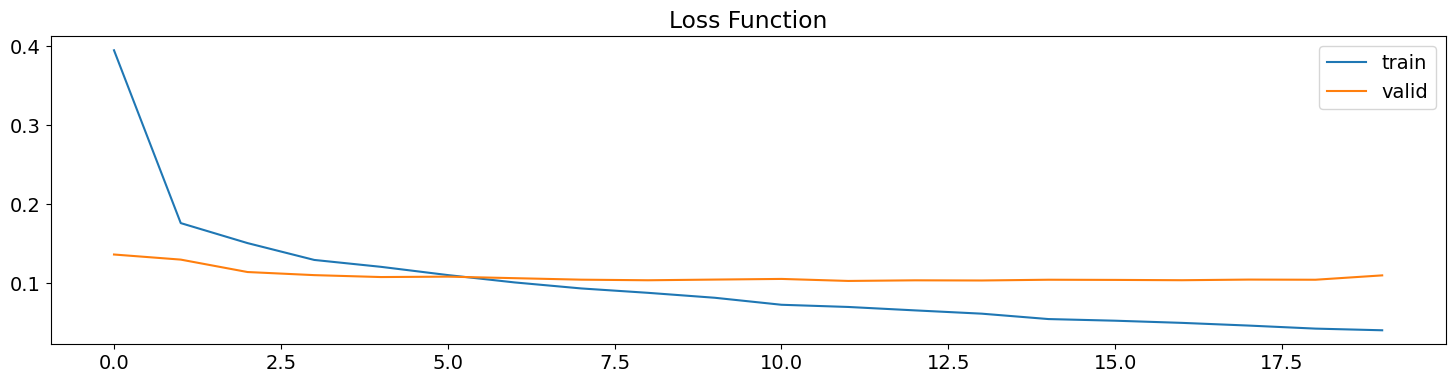

In [10]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

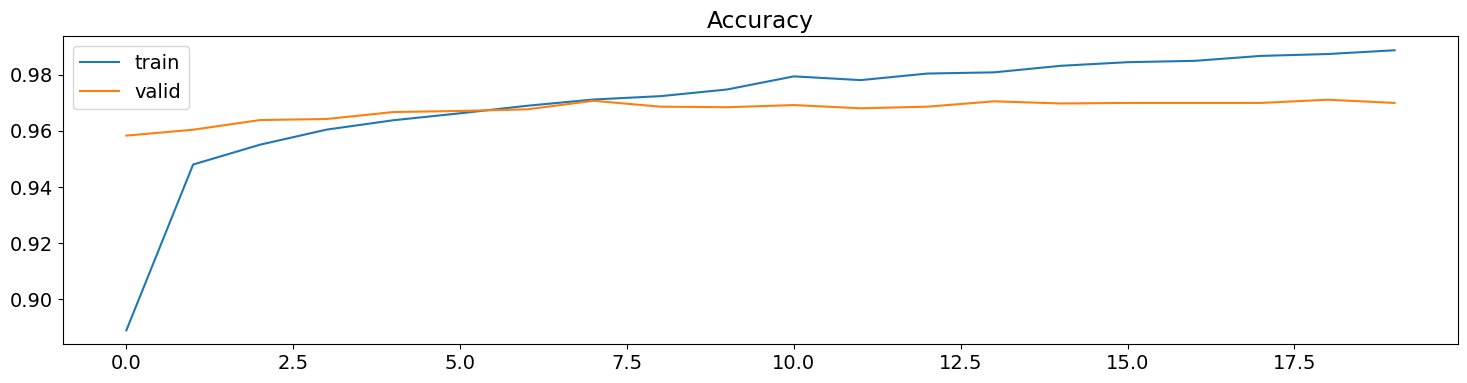

In [12]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

# Conclusion

---



La red neuronal tiene un rendimiento bastante alto. Después de 20 épocas de entrenamiento, la precisión en los datos de entrenamiento alcanza el 98.88%, lo cual indica que el modelo está aprendiendo correctamente a clasificar las imágenes en el conjunto de entrenamiento.

El modelo también es evaluado en un conjunto de validación (que en este caso se está utilizando como conjunto de prueba), y la precisión obtenida es del 96.81%. Esto es una buena señal, ya que indica que el modelo también es capaz de generalizar bien a nuevos datos, no solo a los datos en los que fue entrenado.

El hecho de que la precisión en el conjunto de entrenamiento sea ligeramente mayor que en el conjunto de validación podría indicar un ligero sobreajuste, lo que significa que el modelo puede estar aprendiendo patrones específicos del conjunto de entrenamiento que no necesariamente se aplican a nuevos datos. Sin embargo, la diferencia no es muy grande, lo que sugiere que el sobreajuste no es un problema serio en este caso.

En conclusión, los resultados muestran que el modelo entrenado con la arquitectura InceptionV3 y las capas adicionales tiene un rendimiento muy alto tanto en el conjunto de entrenamiento como en el conjunto de validación.